In [507]:
# pip install --upgrade spacy

Note: you may need to restart the kernel to use updated packages.


In [508]:
# !python -m spacy download en_core_web_md

     ---------------------------------------- 33.5/33.5 MB 6.0 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [509]:
# pip install podium-nlp

Note: you may need to restart the kernel to use updated packages.


In [510]:
# pip install bertopic

In [511]:
# pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [512]:
from tqdm import tqdm
from gensim.utils import simple_preprocess
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
import emoji

In [513]:
# from google.colab import drive
# drive.mount('/content/drive')

In [514]:
# %cd drive/MyDrive/datasets/

In [515]:
df = pd.read_csv("train/SemEval2018-T3-train-taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_test = pd.read_csv("goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_replace = pd.read_csv("test_TaskA/SemEval2018-T3_input_test_taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')

In [516]:
df_test['Tweet text'] = df_test['Tweet text'].apply(emoji.demojize)

In [517]:
def word_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if not x.startswith(("@", "#"))]
    return len(newlist)

def tag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("@")]
    return len(newlist)

def hashtag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("#")]
    return len(newlist)

def has_emoji(s):
    splitted = s.split()
    newlist = [x for x in splitted if x != ":" and x.startswith(":") and x.endswith(":")]
    return len(newlist)

def clean_text(s):
    splitted = s.split()
    newlist = [x for x in splitted if not x.startswith((":", "@", "#"))]
    return ' '.join(newlist)

### dodani featuresi ###
def link_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith(('http:', 'https:'))]
    return len(newlist)

def smiley_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if re.match(r'([\:\;\=][\(\)PDO\/\\\]\[]+)+', x)]
    return len(newlist)

def exclamation_mark_counter(s):
    return s.count('!')

In [518]:
df['length'] = df['Tweet text'].apply(len)
df['word_count'] = df['Tweet text'].apply(word_counter)
df['tag_count'] = df['Tweet text'].apply(tag_counter)
df['hashtag_count'] = df['Tweet text'].apply(hashtag_counter)
df['link_count'] = df['Tweet text'].apply(link_counter)
df['smiley_count'] = df['Tweet text'].apply(smiley_counter)
df['exclamation_mark_count'] = df['Tweet text'].apply(exclamation_mark_counter)
df['has_emoji'] = df['Tweet text'].apply(has_emoji)
df['clean_text'] = df['Tweet text'].apply(clean_text)

In [519]:
nlp = spacy.load("en_core_web_md") # treba instalirat ako nemate, s md cemo dobivat bolji performans a i dalje nije prevelik

In [520]:
df_train = df.sample(frac=0.7)
df_validation = df.drop(df_train.index)

In [521]:
df_train

Tweet index  Label                                         Tweet text  \
3210         3225      0  #MerryChristmas to each and every one of you l...   
296           297      1  People at my school only talk about sex and dr...   
387           388      1  @iPhoneTeam if you don't want to upgrade your ...   
2501         2505      1  Sarcasm incoming: This weekend is going to be ...   
1262         1263      1  Thank you Harding science department for only ...   
...           ...    ...                                                ...   
1923         1927      0  Too blessed to be stressed. So hype for next y...   
3766         3784      0  @CommSec Home page at 8:30am shows Dow -51.44 ...   
1899         1903      1  And then there was none. Goodbye beard (of sor...   
1112         1113      1  There's a reason I don't tell my parents anyth...   
2487         2491      0  @ManUtdstholder @hunts9 You're  familiar with ...   

      length  word_count  tag_count  hashtag_count  link_count  smiley_count  \
3210      72          10          0              2           0             0   
296       62          12          0              0           0             0   
387       89          15          1              0           0             0   
2501     132          24          0              0           0             0   
1262      82          14          0              0           0             0   
...      ...         ...        ...            ...         ...           ...   
1923      84          11          0              1           1             0   
3766     140          21          1              0           1             0   
1899      86          10          0              1           1             0   
1112      98          17          0              0           0             0   
2487      64           5          2              1           0             0   

      exclamation_mark_count  has_emoji  \
3210                       1          0   
296                        0          0   
387                        0          0   
2501                       1          0   
1262                       0          0   
...                      ...        ...   
1923                       1          0   
3766                       0          0   
1899                       0          0   
1112                       0          0   
2487                       0          0   

                                             clean_text  
3210         to each and every one of you lovely lot! X  
296   People at my school only talk about sex and dr...  
387   if you don't want to upgrade your iOS or keep ...  
2501  Sarcasm incoming: This weekend is going to be ...  
1262  Thank you Harding science department for only ...  
...                                                 ...  
1923  Too blessed to be stressed. So hype for next y...  
3766  Home page at 8:30am shows Dow -51.44 but it's ...  
1899  And then there was none. Goodbye beard (of sor...  
1112  There's a reason I don't tell my parents anyth...  
2487                   You're familiar with Matt Bubsy,  

[2672 rows x 12 columns]

## Preprocessing for topic modelling

In [522]:
tweet_text_train = df_train[['Tweet text']]
tweet_text_validation = df_validation[['Tweet text']]
tweet_text_test = df_test[['Tweet text']]

print(tweet_text_train.shape)
tweet_text_train.head(15)

(2672, 1)


Tweet text
3210  #MerryChristmas to each and every one of you l...
296   People at my school only talk about sex and dr...
387   @iPhoneTeam if you don't want to upgrade your ...
2501  Sarcasm incoming: This weekend is going to be ...
1262  Thank you Harding science department for only ...
1131  I swear . I can  stand little fucking girl. I ...
1964  internet got me like :weary_face: #stillalive ...
3088  @being_Akash_ nice to know that you give me so...
1820  #Legend says if you stand in front of a mirror...
2462     Yay for knee machines!  http://t.co/BNK8Z2LBsE
2239  http://t.co/yvziKeKAvT #TeenAnalCasting #She S...
397   Finals Week is draining my body so much that i...
1658            I'm so glad I'm sick today. | #bullcrap
2444  Aww I've just seen the pictures of @ben_botica...
918                   @UberStaub you have never seen me

In [523]:
def preprocess_words(s):
    '''
    Removes tags, emojis, links, smiley faces, hashtag signs, 
    stopwords and changes the case to lower.
    '''
    ret_list = []

    smiley_regex = r'([\:\;\=][\(\)PDO\/\\\]\[]+)+'
    
    is_tag = lambda w: w.startswith('@')
    is_vertical_line = lambda w: w.startswith('|')
    is_emoji = lambda w: w != ':' and w.startswith(':') and w.endswith(':')
    remove_emoji = lambda w: w[:w.index(':')] + w[w.rindex(':')+1:] if ':' in w and w.index(':') != w.rindex(':') else w
    is_link = lambda w: w.startswith("http") or w.startswith("https")
    is_hashtag = lambda w: w.startswith("#")
    is_smiley = lambda w: re.match(smiley_regex, w)
    
    for i, s_i in enumerate(s):
        w_arr = s_i.split()
        w2 = []
        for w in w_arr:
            if is_tag(w) or is_emoji(w) or is_link(w) or is_vertical_line(w):
                continue
            
            elif is_hashtag(w):
                w_tmp = w.replace('#', '')
                if w_tmp != '':
                    lower_append(w_tmp, w2)
            
            elif is_smiley(w):
                w_tmp = re.sub(smiley_regex, '', w)
                if w_tmp != '':
                    lower_append(w_tmp, w2)
            
            else:
                if w != '':
                    w.replace('#', '')
                    w.replace('|', '')
                    w.replace('_', '')
                    lower_append(w, w2)

        ret_list.append(' '.join(w2))
    return ret_list

def lower_append(w, l):
    l.append(w.lower())

tweet_text_train = tweet_text_train.apply(preprocess_words)
tweet_text_validation = tweet_text_validation.apply(preprocess_words)
tweet_text_test = tweet_text_test.apply(preprocess_words)


In [524]:
print(tweet_text_train.shape)
tweet_text_train.head(15)

(2672, 1)


Tweet text
3210  merrychristmas to each and every one of you lo...
296   people at my school only talk about sex and dr...
387   if you don't want to upgrade your ios or keep ...
2501  sarcasm incoming: this weekend is going to be ...
1262  thank you harding science department for only ...
1131  i swear . i can stand little fucking girl. i w...
1964                    internet got me like stillalive
3088  nice to know that you give me so much importan...
1820  legend says if you stand in front of a mirror+...
2462                             yay for knee machines!
2239             teenanalcasting she she sucked me dry!
397   finals week is draining my body so much that i...
1658               i'm so glad i'm sick today. bullcrap
2444  aww i've just seen the pictures of from today,...
918                              you have never seen me

In [525]:
def simple_preprocessing(s):
    '''Lowercases, tokenizes, de-accents, removes words shorter than 3 and longer than 14 characters'''
    return [' '.join(simple_preprocess(s_i)) for s_i in s]

tweet_text_train = tweet_text_train.apply(simple_preprocessing)
tweet_text_validation = tweet_text_validation.apply(simple_preprocessing)
tweet_text_test = tweet_text_test.apply(simple_preprocessing)

In [526]:
print(tweet_text_train.shape)
tweet_text_train.head(15)

(2672, 1)


Tweet text
3210  merrychristmas to each and every one of you lo...
296   people at my school only talk about sex and dr...
387   if you don want to upgrade your ios or keep ma...
2501  sarcasm incoming this weekend is going to be s...
1262  thank you harding science department for only ...
1131  swear can stand little fucking girl want to pu...
1964                    internet got me like stillalive
3088   nice to know that you give me so much importance
1820  legend says if you stand in front of mirror sa...
2462                              yay for knee machines
2239              teenanalcasting she she sucked me dry
397   finals week is draining my body so much that i...
1658                        so glad sick today bullcrap
2444  aww ve just seen the pictures of from today ho...
918                              you have never seen me

In [527]:
def remove_tuple_characters(s):
    return [re.sub(r'(.)\1{2,}', r'\1', w) for w in s]

tweet_text_train = tweet_text_train.apply(remove_tuple_characters)
tweet_text_validation = tweet_text_validation.apply(remove_tuple_characters)
tweet_text_test = tweet_text_test.apply(remove_tuple_characters)

print(tweet_text_train.shape)
tweet_text_train.head(15)

(2672, 1)


Tweet text
3210  merrychristmas to each and every one of you lo...
296   people at my school only talk about sex and dr...
387   if you don want to upgrade your ios or keep ma...
2501  sarcasm incoming this weekend is going to be s...
1262  thank you harding science department for only ...
1131  swear can stand little fucking girl want to pu...
1964                    internet got me like stillalive
3088   nice to know that you give me so much importance
1820  legend says if you stand in front of mirror sa...
2462                              yay for knee machines
2239              teenanalcasting she she sucked me dry
397   finals week is draining my body so much that i...
1658                        so glad sick today bullcrap
2444  aww ve just seen the pictures of from today ho...
918                              you have never seen me

In [528]:
def lemmatize(s):
    '''Lemmatizes the words in the sentences and returns them if theyre not stopwords or punctuation'''
    return [[w.lemma_.lower() for w in nlp(s_i) if w.lemma_.lower() not in nlp.Defaults.stop_words and not w.is_punct] for s_i in s]

tweet_text_train = tweet_text_train.apply(lemmatize)
tweet_text_validation = tweet_text_validation.apply(lemmatize)
tweet_text_test = tweet_text_test.apply(lemmatize)

In [529]:
tweet_text_train.head(15)

Tweet text
3210         [merrychristma, lovely, lot, peaceonearth]
296          [people, school, talk, sex, drug, awesome]
387      [don, want, upgrade, io, picture, yeah, great]
2501  [sarcasm, income, weekend, great, time, ground...
1262  [thank, harding, science, department, minute, ...
1131  [swear, stand, little, fucking, girl, want, pu...
1964                       [internet, like, stillalive]
3088                           [nice, know, importance]
1820  [legend, stand, mirror, time, girl, yogapant, ...
2462                               [yay, knee, machine]
2239                         [teenanalcaste, suck, dry]
397   [final, week, drain, body, ruin, life, place, ...
1658                      [glad, sick, today, bullcrap]
2444  [aww, ve, picture, today, s, recovery, getwell...
918                                                  []

In [532]:
tweet_text_train['Label'] = df_train['Label']
tweet_text_validation['Label'] = df_validation['Label']
tweet_text_test['Label'] = df_test['Label']

In [533]:
tweet_text_train.head(15)

Tweet text  Label
3210         [merrychristma, lovely, lot, peaceonearth]      0
296          [people, school, talk, sex, drug, awesome]      1
387      [don, want, upgrade, io, picture, yeah, great]      1
2501  [sarcasm, income, weekend, great, time, ground...      1
1262  [thank, harding, science, department, minute, ...      1
1131  [swear, stand, little, fucking, girl, want, pu...      0
1964                       [internet, like, stillalive]      1
3088                           [nice, know, importance]      1
1820  [legend, stand, mirror, time, girl, yogapant, ...      0
2462                               [yay, knee, machine]      1
2239                         [teenanalcaste, suck, dry]      0
397   [final, week, drain, body, ruin, life, place, ...      1
1658                      [glad, sick, today, bullcrap]      1
2444  [aww, ve, picture, today, s, recovery, getwell...      0
918                                                  []      0

In [541]:
def join_docs(s):
    '''Joins the strings inside the inner list of a nested list'''
    return ' '.join(s)

tweet_text_train['Tweet text'] = tweet_text_train['Tweet text'].apply(join_docs)
tweet_text_validation['Tweet text'] = tweet_text_validation['Tweet text'].apply(join_docs)
tweet_text_test['Tweet text'] = tweet_text_test['Tweet text'].apply(join_docs)

In [547]:
tweet_text_train = tweet_text_train[tweet_text_train['Tweet text'] != '']
tweet_text_validation = tweet_text_validation[tweet_text_validation['Tweet text'] != '']
tweet_text_test = tweet_text_test[tweet_text_test['Tweet text'] != '']

In [548]:
tweet_text_train.head(15)

Tweet text  Label
3210              merrychristma lovely lot peaceonearth      0
296                 people school talk sex drug awesome      1
387              don want upgrade io picture yeah great      1
2501  sarcasm income weekend great time ground homew...      1
1262      thank harding science department minute final      1
1131  swear stand little fucking girl want punch fuc...      0
1964                           internet like stillalive      1
3088                               nice know importance      1
1820  legend stand mirror time girl yogapant appear ...      0
2462                                   yay knee machine      1
2239                             teenanalcaste suck dry      0
397        final week drain body ruin life place lovely      1
1658                           glad sick today bullcrap      1
2444        aww ve picture today s recovery getwellsoon      0
2043  rdeye brand design accessory easy carry comfor...      0

## Topic modeling baselines

In [553]:
count_vectorizer = CountVectorizer(
    analyzer='word',
    min_df=20,
    max_df=0.5,
)

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    min_df=20,
    max_df=0.5,
)

tweet_text_count_train = count_vectorizer.fit_transform(tweet_text_train['Tweet text'])
tweet_text_count_validation = count_vectorizer.transform(tweet_text_validation['Tweet text'])
tweet_text_count_test = count_vectorizer.transform(tweet_text_test['Tweet text'])

tweet_text_tfidf_train = tfidf_vectorizer.fit_transform(tweet_text_train['Tweet text'])
tweet_text_tfidf_validation = tfidf_vectorizer.transform(tweet_text_validation['Tweet text'])
tweet_text_tfidf_test = tfidf_vectorizer.transform(tweet_text_test['Tweet text'])

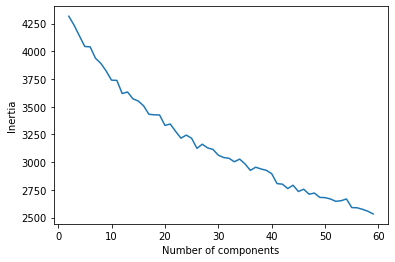

In [554]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

inertia = []
range_ = list(range(2, 60))
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_count_train)
    inertia.append(model.inertia_)
    
plt.plot(range_, inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

In [558]:
model = KMeans(26)
model.fit(tweet_text_count_train)

kmeans_count_labels_train = model.predict(tweet_text_count_train)
kmeans_count_labels_validation = model.predict(tweet_text_count_validation)
kmeans_count_labels_test = model.predict(tweet_text_count_test)

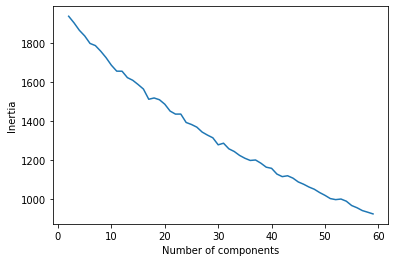

In [557]:
inertia = []
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_tfidf_train)
    inertia.append(model.inertia_)
plt.plot(range_, inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

In [559]:
model = KMeans(17)
model.fit(tweet_text_count_train)

kmeans_tfidf_labels_train = model.predict(tweet_text_count_train)
kmeans_tfidf_labels_validation = model.predict(tweet_text_count_validation)
kmeans_tfidf_labels_test = model.predict(tweet_text_count_test)

In [563]:
!pip install bertopic

  Using cached bertopic-0.10.0-py2.py3-none-any.whl (58 kB)
  Using cached plotly-5.8.0-py2.py3-none-any.whl (15.2 MB)
  Using cached PyYAML-5.4.1-cp39-cp39-win_amd64.whl (213 kB)
  Using cached hdbscan-0.8.28.tar.gz (5.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached umap_learn-0.5.3-py3-none-any.whl
  Using cached sentence_transformers-2.2.0-py3-none-any.whl
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
  Using cached sentencepiece-0.1.96-cp39-cp39-win_amd64.whl (1.1 MB)
  Using cached torchvision-0.12.0-cp39-cp39-win_amd64.whl (1.0 MB)
  Using cached pynndescent-0.5.7-py3-none-any.whl
  Using cached numpy-1.21.6-cp39-cp39-win_amd64.whl (14.0 MB)
Failed to build hdbscan


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [40 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\flat.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\hdbscan_.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\plots.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\prediction.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\robust_single_linkage_.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\validity.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\__init__.py -> build\lib.win-amd64-cpython-39\hdbscan
  creating build\lib.win-amd64-cpython-39\hdbscan\tests
  copying hdbscan\tests\test_flat.py -> build\lib.win-amd64-cpython-39\hdbscan\tests
  copying hdbscan\tests\test_hdbscan.py -> build\lib.win-amd64-cpython-39\hdbscan\tests
  copying 

### BERTopic

In [560]:
from bertopic import BERTopic

topic_model = BERTopic(min_topic_size=20)
topics, probs = topic_model.fit_transform(tweet_text_train)
predictions = topic_model.transform(tweet_text_test)

ModuleNotFoundError: No module named 'bertopic'

In [ ]:
topic_model.get_topic(0)

In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_model.transform

## Embedding

In [564]:
from podium import Vocab, Field, LabelField
from podium.datasets import TabularDataset
from podium.vectorizers import GloVe

In [566]:
tweet_embedding_train = tweet_text_train[['Tweet text', 'Label']]
tweet_embedding_validation = tweet_text_validation[['Tweet text', 'Label']]
tweet_embedding_test = tweet_text_test[['Tweet text', 'Label']]

In [567]:
tweet_embedding_train.reset_index(drop=True, inplace=True)
tweet_embedding_validation.reset_index(drop=True, inplace=True)
tweet_embedding_test.reset_index(drop=True, inplace=True)

In [576]:
max_vocab_size = 10_000
vocab = Vocab(max_size=max_vocab_size, min_freq=20)

TWEET = Field('Tweet text', numericalizer=vocab)
LABEL = LabelField('Label')

fields = [TWEET, LABEL]

train = TabularDataset.from_pandas(tweet_embedding_train, fields)
validation = TabularDataset.from_pandas(tweet_embedding_validation, fields)
test = TabularDataset.from_pandas(tweet_embedding_test, fields)
train.finalize_fields()

glove = GloVe()
embeddings = glove.load_vocab(vocab)

train_batch = train.batch(add_padding=True)
validation_batch = validation.batch(add_padding=True)
test_batch = test.batch(add_padding=True)

In [584]:
train_batch['Tweet text'].astype(int)[0:5]

array([[ 0,  0, 78,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1],
       [ 8, 86, 43,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1],
       [12, 17,  0,  0,  0, 51,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  6,  9,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1],
       [16,  0,  0,  0,  0, 99,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1]])

In [578]:
tweet_train = embeddings[train_batch['Tweet text'].astype(int)]
tweet_validation = embeddings[validation_batch['Tweet text'].astype(int)]
tweet_test = embeddings[test_batch['Tweet text'].astype(int)]

# Mean
tweet_train_mean = tweet_train.mean(axis=1)
tweet_validation_mean = tweet_validation.mean(axis=1)
tweet_test_mean = tweet_test.mean(axis=1)

# Median
tweet_train_median = np.median(tweet_train, axis=1)
tweet_validation_median = np.median(tweet_validation, axis=1)
tweet_test_median = np.median(tweet_test, axis=1)

# Variance
tweet_train_std = tweet_train.std(axis=1)
tweet_validation_std = tweet_validation.std(axis=1)
tweet_test_std = tweet_test.std(axis=1)

In [580]:
embeddings_train_mean_df = pd.DataFrame(tweet_train_mean)
tweet_embedding_train = pd.merge(tweet_embedding_train, embeddings_train_mean_df, left_index=True, right_index=True)

embeddings_validation_mean_df = pd.DataFrame(tweet_validation_mean)
tweet_embedding_validation = pd.merge(tweet_embedding_validation, embeddings_validation_mean_df, left_index=True, right_index=True)

embeddings_test_mean_df = pd.DataFrame(tweet_test_mean)
tweet_embedding_test = pd.merge(tweet_embedding_validation, embeddings_test_mean_df, left_index=True, right_index=True)

In [582]:
tweet_embedding_test.head()

Tweet text  Label       0_x  \
0  sweet united nations video time christmas imag...      1  0.165704   
1                      great mobile bill arrive text      1  0.211346   
2              trading sp defense ss brilliant trade      1  0.177576   
3    need second hand embarrassment desperatly phone      1  0.185102   
4                                      time hit book      1  0.240504   

        1_x       2_x       3_x       4_x       5_x       6_x       7_x  ...  \
0 -0.945607  2.167666 -0.249754  0.975262 -0.272225 -0.363571  0.249220  ...   
1 -0.985573  2.263277 -0.251805  0.990235 -0.301721 -0.405034  0.306234  ...   
2 -0.970943  2.237702 -0.259217  1.009163 -0.292165 -0.374002  0.256157  ...   
3 -0.969764  2.227472 -0.253196  0.990886 -0.292344 -0.384282  0.276332  ...   
4 -1.007681  2.324352 -0.239832  0.972472 -0.329254 -0.447370  0.359476  ...   

      290_y     291_y     292_y     293_y     294_y     295_y     296_y  \
0 -0.089896  0.484842  0.197397 -0.705230  0.412184 -0.025224 -0.340979   
1 -0.093031  0.589302  0.183024 -0.749315  0.438833 -0.033189 -0.398900   
2 -0.149455  0.539555  0.875055 -1.434898  0.661025  0.382209 -0.776563   
3 -0.111887  0.609890  0.470417 -1.050991  0.536555  0.153649 -0.560905   
4 -0.103280  0.578273 -0.374470 -0.213096  0.274030 -0.263653 -0.052040   

      297_y     298_y     299_y  
0 -1.143486 -0.243777  0.284303  
1 -1.275403 -0.222073  0.298935  
2 -1.262931 -0.864805  1.012460  
3 -1.326528 -0.489911  0.577798  
4 -1.195988  0.214041 -0.259379  

[5 rows x 602 columns]

In [ ]:
## Features
## Broj neg rijeci
## Broj poz rijeci
## Omjer
## Udaljenost izmedu poz i neg rijeci

Potrebno dodatno preprocesat da samo rjeci ostanu

In [ ]:
import nltk
nltk.download('vader_lexicon') # if error run this

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import copy

def pos_neg_words(df, limit):
    sid = SentimentIntensityAnalyzer()

    neg_words = []
    neg_word_count = []
    pos_words = []
    pos_word_count = []
    for index, row in df.iterrows():
        lemmas = []
        if len(row['clean_text']) > 0:
            doc = nlp(row['clean_text'])
            for token in doc:
                lemmas.append(token.lemma_)

            current_pos = []
            current_neut = []
            current_neg = []
            for word in lemmas:
                if (sid.polarity_scores(word)['compound']) >= limit:
                    current_pos.append(word)
                elif (sid.polarity_scores(word)['compound']) <= -limit:
                    current_neg.append(word)
                else:
                    current_neut.append(word)

            neg_words.append(copy.copy(current_neg))
            neg_word_count.append(copy.copy(len(current_neg)))
            pos_words.append(copy.copy(current_pos))
            pos_word_count.append(copy.copy(len(current_pos)))
        else:
            neg_words.append([])
            neg_word_count.append(0)
            pos_words.append([])
            pos_word_count.append(0)
    return neg_words, neg_word_count, pos_words, pos_word_count

In [ ]:
df_train

In [ ]:
neg_words_train, neg_word_count_train, pos_words_train, pos_word_count_train = pos_neg_words(df_train, 0.2)
neg_words_val, neg_word_count_val, pos_words_val, pos_word_count_val = pos_neg_words(df_validation, 0.2)

In [ ]:
df_train['neg_word_count'] = neg_word_count_train
df_train['neg_word'] = neg_words_train
df_train['pos_word_count'] = pos_word_count_train
df_train['pos_word'] = pos_words_train
df_train

In [ ]:
df_validation['neg_word_count'] = neg_word_count_val
df_validation['neg_word'] = neg_words_val
df_validation['pos_word_count'] = pos_word_count_val
df_validation['pos_word'] = pos_words_val

In [ ]:
from sklearn.linear_model import LogisticRegression
X_ = df_train[['neg_word_count', 'pos_word_count']]
y_ = df_train['Label']
clf = LogisticRegression(random_state=0).fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))
print('Validation score')
X_val = df_validation[['neg_word_count', 'pos_word_count']]
y_val = df_validation['Label']
print(clf.score(X_val, y_val))

In [ ]:
## Pos and neg words within 4 words
df_train[['clean_text', 'pos_word', 'pos_word_count', 'neg_word', 'neg_word_count']].iloc[25]

In [ ]:
def pos_neg_within_n(df, n=4):

    ret_array = []

    for index, row in df.iterrows():
        if row['pos_word_count'] > 0 and row['neg_word_count'] > 0:
            doc = nlp(row['clean_text'])
            lemmas = []
            for token in doc:
                lemmas.append(token.lemma_)

            pos_indexes = np.array([])
            for word in row['pos_word']:
                pos_indexes = np.append(pos_indexes, np.where(np.array(lemmas) == word))
            neg_indexes = np.array([])
            for word in row['neg_word']:
                neg_indexes = np.append(neg_indexes, np.where(np.array(lemmas) == word))

            bool_val = 0
            for idx in pos_indexes:
                if (abs(neg_indexes-idx) < n).any():
                    bool_val = 1
            ret_array.append(copy.copy(bool_val))
        else:
            ret_array.append(0)
    return ret_array

In [ ]:
within_5_train = pos_neg_within_n(df_train, n=5)
within_5_val = pos_neg_within_n(df_validation, n=5)

In [ ]:
df_train['pos_neg_within_5'] = within_5_train
df_validation['pos_neg_within_5'] = within_5_val
df_train

In [ ]:
X_ = df_train[[ 'pos_neg_within_5']]
y_ = df_train['Label']
clf = LogisticRegression().fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))
print('Validation score')
X_val = df_validation[[ 'pos_neg_within_5']]
y_val = df_validation['Label']
print(clf.score(X_val, y_val))

In [ ]:
within_5_val

### Grid search

1. treba koristit tweet_text_train, tweet_text_validation i tweet_text_test s kombiniranim znacajkama iz df_train, df_validation, df_test, a ne da samo koristi embeddinge - ako ne radi bolje tako onda cemo odjebat embeddinge
2. grid mora koristit minimalno feature selekciju, skaliranje i model (za dtc ne treba skalirat, lr moze i polynomial transform)
3. pazi na data leakove, nemres fitat search i onda evaluirat na njemu test, treba natrenirat novi model s tim najboljim hiperparametrima na trainu i onda predictat na testu
4. povecat broj parametara, ovo je jako slabo, grid se vrti po 30ak sekundi

In [607]:
X_ = df_train.drop(columns=['Tweet index', 'Label', 'Tweet text', 'clean_text'], axis=1)
y_ = df_train['Label']

X_val = df_validation.drop(['Tweet index', 'Label', 'Tweet text', 'clean_text'], axis=1)
y_val = df_validation['Label']

X_test = df_test.drop(['Tweet index', 'Label', 'Tweet text'], axis=1)
y_test = df_test['Label']

In [618]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report

pipeline_lr = Pipeline([
    ('selection', SelectKBest()), 
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'selection__k': list(range(2, 20, 3)),
    'lr__penalty': ['l1', 'l2', 'elasticnet'], 
    'lr__C': np.logspace(-4, 4, 20), 
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(X_, y_)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6051566383142568
Best score: {'lr__C': 0.08858667904100823, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg', 'selection__k': 8}


In [617]:
pipeline_lr_best = Pipeline([
    ('selection', SelectKBest(k=8)), 
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=0.0885, penalty='l2', solver='newton-cg'))
])

pipeline_lr_best.fit(X_, y_)
y_train_pred = pipeline_lr_best.predict(X_)
print(classification_report(y_train_pred, y_))

y_validation_pred = pipeline_lr_best.predict(X_val)
print(classification_report(y_validation_pred, y_val))

              precision    recall  f1-score   support

           0       0.51      0.64      0.57      1073
           1       0.71      0.58      0.64      1599

    accuracy                           0.60      2672
   macro avg       0.61      0.61      0.60      2672
weighted avg       0.63      0.60      0.61      2672

              precision    recall  f1-score   support

           0       0.53      0.63      0.58       467
           1       0.71      0.62      0.66       678

    accuracy                           0.62      1145
   macro avg       0.62      0.63      0.62      1145
weighted avg       0.64      0.62      0.63      1145



In [ ]:
from sklearn.tree import DecisionTreeClassifier

params = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' : ['gini', 'entropy', 'log_loss']
             }


X_ = df_train.drop(['Tweet index', 'Label', 'Tweet text', 'clean_text', 'pos_word', 'neg_word'], axis=1)
y_ = df_train['Label']
clf = DecisionTreeClassifier()

model = GridSearchCV(clf, param_grid=params, cv=5)

model.fit(X_, y_)

print('Train score')
print(model.score(X_, y_))
print('Validation score')
X_val = df_validation.drop(['Tweet index', 'Label', 'Tweet text', 'clean_text', 'pos_word', 'neg_word'], axis=1)
y_val = df_validation['Label']
print(model.score(X_val, y_val))